# 안정적인 학습을 위한 기법들

옛날에 학습이 불안정했던 이유와 현재는 어떻게 해결하고 있는지 살펴봅시다.

1. `logit 값 비슷하게 만들기`
2. `kaiming initialization`
3. `batch normalization`

# (늘 하던 대로) 준비

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
names = open('../names.txt').read().splitlines()
chars = list(set(''.join(names)))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [3]:
def build_dataset(words):
    block_size = 3
    X,Y = [], []
    for w in words:
        # print(w)
        context = [0] * block_size

        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', ch)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [4]:
import random
random.seed(42)
random.shuffle(names)
n1 = int(len(names)*0.8)
n2 = int(len(names)*0.9)

Xtr, Ytr = build_dataset(names[:n1])
Xdev, Ydev = build_dataset(names[n1:n2])
Xte, Yte = build_dataset(names[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


# 첫번째 학습 스텝 loss 최소화하기

In [5]:
block_size = 3
vocab_size = 27
n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed), generator=g)
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [6]:
# 첫번째 step loss 구하기
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += - lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())
    if i==20000:
        break

      0/ 200000: 24.4450
  10000/ 200000: 2.5942
  20000/ 200000: 2.5127


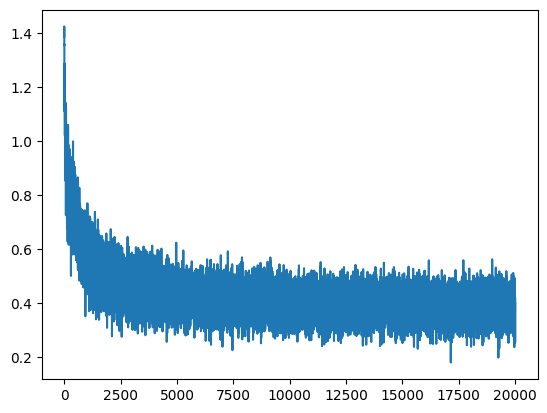

In [7]:
plt.plot(lossi)

In [8]:
@torch.no_grad
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.450122594833374
val 2.4597623348236084


첫번째 스텝 학습 loss 혼자 너무 큽니다.   
처음 가중치 초기화했을 때 랜덤이라   
logit에서 올바르지 않은 값이 높기 때문입니다.

## logits을 모두 비슷한 값으로 하면 loss 작아짐
예시로 4차원 logits을 봅시다.

In [9]:
# 랜덤한 logit (가중치 초기화)
logits = torch.randn(4)
probs = F.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([ 1.9242, -0.9933, -0.3269, -0.5102]),
 tensor([0.8019, 0.0434, 0.0844, 0.0703]),
 tensor(2.4718))

위 셀을 실행할 때마다 편차가 심하고, loss 값이 클 때도 많습니다.

In [10]:
logits = torch.tensor([0,0,0,0]).float()
probs = F.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([0., 0., 0., 0.]),
 tensor([0.2500, 0.2500, 0.2500, 0.2500]),
 tensor(1.3863))

모델 가중치 초기화할 때   
최대한 output layer 가중치를 작은 값으로 하면   
첫번째 학습 스텝에서 lgotis 값이 모두 0에 가까워지고, 작은 loss를 보장할 수 있습니다.

In [11]:
block_size = 3
vocab_size = 27
n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed), generator=g)
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [12]:
# 첫번째 step loss 구하기
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += - lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())
    if i==20000:
        break

      0/ 200000: 3.2773
  10000/ 200000: 2.0836
  20000/ 200000: 2.4032


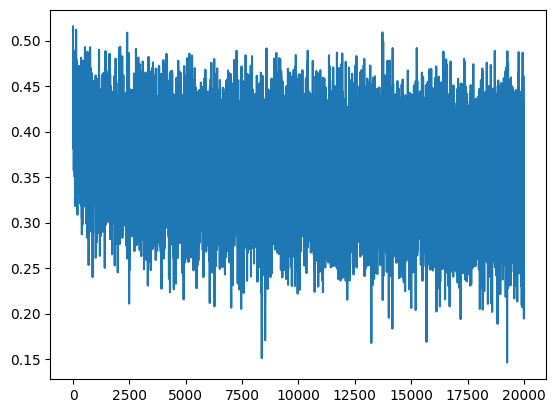

In [13]:
plt.plot(lossi)

In [14]:
@torch.no_grad
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.2428572177886963
val 2.27639102935791


# tanh의 초기 saturation 문제
첫번째 스텝 학습해보면   
`tanh`가 문제라는 걸 알 수 있습니다.

In [15]:
block_size = 3
vocab_size = 27
n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed), generator=g)
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [16]:
# 첫번째 step loss 구하기
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += - lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())
    break

      0/ 200000: 3.2773


(array([  2.,   0.,   2.,   1.,   2.,   5.,  10.,  12.,  19.,  23.,  32.,
         66.,  57.,  74.,  97., 153., 191., 188., 269., 300., 297., 315.,
        374., 387., 415., 409., 388., 403., 314., 282., 280., 214., 193.,
        152., 141.,  81.,  78.,  51.,  30.,  29.,  22.,  11.,   6.,  10.,
          4.,   3.,   2.,   4.,   1.,   1.]),
 array([-20.68962097, -19.83994656, -18.99027214, -18.14059772,
        -17.29092331, -16.44124889, -15.59157448, -14.74190006,
        -13.89222565, -13.04255123, -12.19287682, -11.3432024 ,
        -10.49352798,  -9.64385357,  -8.79417915,  -7.94450474,
         -7.09483032,  -6.24515591,  -5.39548149,  -4.54580708,
         -3.69613266,  -2.84645824,  -1.99678383,  -1.14710941,
         -0.297435  ,   0.55223942,   1.40191383,   2.25158825,
          3.10126266,   3.95093708,   4.8006115 ,   5.65028591,
          6.49996033,   7.34963474,   8.19930916,   9.04898357,
          9.89865799,  10.74833241,  11.59800682,  12.44768124,
         13.297355

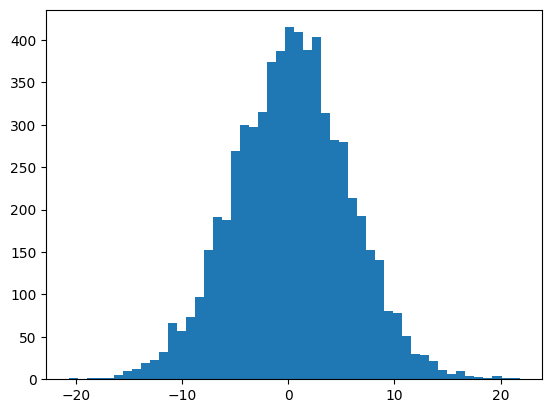

In [17]:
# tanh 입력값 hpreact 분포 확인 (tanh 그래프와 함께 봅시다)
plt.hist(hpreact.view(-1).tolist(), bins=50)

In [18]:
# tanh 입력값이 5만 넘어도 이미 0.9999
torch.tanh(torch.tensor([5])), torch.tanh(torch.tensor([-5]))

(tensor([0.9999]), tensor([-0.9999]))

(array([2143.,  144.,  101.,   73.,   47.,   54.,   31.,   36.,   28.,
          26.,   30.,   35.,   23.,   24.,   26.,   11.,   27.,   21.,
          31.,   18.,   25.,   36.,   30.,   16.,   11.,   16.,   19.,
          25.,   13.,   18.,   18.,   17.,   25.,   14.,   24.,   19.,
          27.,   26.,   26.,   32.,   30.,   37.,   46.,   34.,   45.,
          57.,   72.,  111.,  168., 2434.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

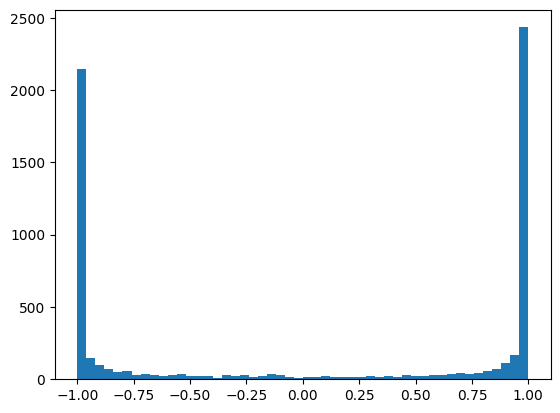

In [19]:
# h값 분포 확인
plt.hist(h.view(-1).tolist(), bins=50)

$\text{tanh}$ 값이 -1과 1에 치우쳐져 있으면 gradient가 0이 되어 학습이 잘 안됩니다.   
$\text{tanh}(x)$ 미분하면 $1-\text{tanh}^2(x)$라서   
$\text{tanh}$ 값이 1과 -1에 가까울수록 기울기가 0 $\rightarrow$ 학습이 잘 안됩니다

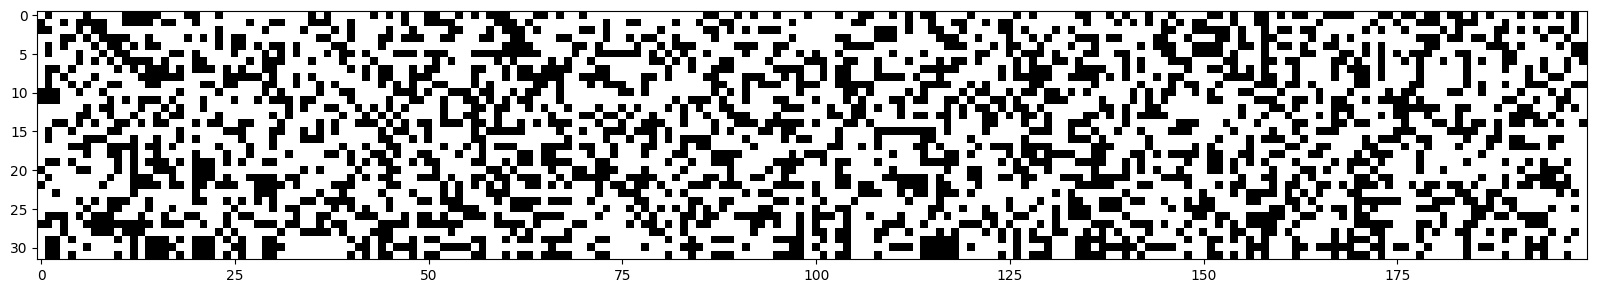

In [20]:
# h의 절댓값 중 0.99 이상인 것 확인
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99, cmap='gray', interpolation='nearest')

위 그림에서 흰 부분이 $h>0.99$, 즉 그레디언트가 0에 가까운 부분입니다.   
그렇게 되면 `tanh` 그레디언트에 영향을 받는 `W1`, `b1`의 그레디언트도 매우 작아집니다.   

- forward: `W1 b1` -> `Tanh` -> `W2 b2`
- backward: `W2 b2` -> `Tanh` -> `W1 b1`

지금은 모델 층이 깊지 않아서 괜찮아보이지만   
층이 깊어질수록 이 문제는 더 심해집니다.   

`W4 b4` -> `Tanh` -> `W3 b3` -> `Tanh` -> `W2 b2` -> `Tanh` ...

In [21]:
W1.grad, b1.grad

(tensor([[ 5.0394e-05,  1.1960e-04,  1.0627e-03,  ..., -1.2416e-03,
          -2.9007e-04, -6.0323e-05],
         [-2.9791e-04, -1.6277e-04, -1.1066e-04,  ...,  2.9465e-04,
           1.9630e-04, -1.1941e-05],
         [ 9.0190e-05,  1.2507e-04,  2.7074e-06,  ...,  1.3208e-06,
           2.0281e-04,  1.6219e-05],
         ...,
         [-2.7133e-05,  4.3433e-04,  3.3219e-04,  ..., -7.4785e-04,
           8.1063e-05, -4.0882e-05],
         [ 1.3584e-04, -1.9543e-04,  8.3813e-05,  ...,  2.4598e-04,
           1.8360e-05, -2.8113e-05],
         [ 1.9768e-04, -3.2049e-04,  6.8855e-04,  ..., -1.5142e-05,
           2.2366e-04, -5.6744e-05]]),
 tensor([-3.4363e-04, -4.6032e-04,  3.7543e-04, -2.3602e-04, -8.8117e-05,
         -7.0214e-04, -1.1422e-04, -3.4755e-04,  1.0825e-03,  4.9973e-04,
          1.0144e-04, -5.5904e-04, -8.3493e-04,  2.4804e-04,  2.8737e-04,
          2.0228e-04, -4.1219e-04,  5.2899e-04, -2.7035e-04,  2.4835e-04,
          1.2482e-03, -8.6344e-04,  3.4553e-04,  8.6960e-0

In [22]:
W2.grad, b2.grad

(tensor([[ 0.0317,  0.0215, -0.0111,  ..., -0.0101, -0.0094, -0.0417],
         [ 0.0013,  0.0030, -0.0021,  ..., -0.0044,  0.0129,  0.0275],
         [ 0.0237, -0.0386, -0.0063,  ..., -0.0105, -0.0074,  0.0233],
         ...,
         [ 0.0257,  0.0289, -0.0012,  ..., -0.0025, -0.0366,  0.0294],
         [ 0.1810, -0.0255,  0.0073,  ...,  0.0071,  0.0034,  0.0349],
         [-0.1400, -0.0159,  0.0155,  ...,  0.0156,  0.0165, -0.0161]]),
 tensor([-0.2429,  0.0056,  0.0347, -0.0554,  0.0061, -0.0267,  0.0362, -0.0244,
          0.0399,  0.0055,  0.0044, -0.0524,  0.0366,  0.0036,  0.0363,  0.0386,
          0.0345,  0.0067,  0.0397,  0.0051,  0.0052,  0.0362,  0.0355, -0.0270,
          0.0373, -0.0227,  0.0036]))

## 해결책: hpreact 값을 0 주변으로 모이게 만들기

`tanh`의 입력값(hpreact)을 0 주변으로 하면   
`tanh`가 1 또는 -1이 안되겠죠?

`W1`, `b1`을 작게 하면 됩니다.

In [23]:
block_size = 3
vocab_size = 27
n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed), generator=g)
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [24]:
# 첫번째 step loss 구하기
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += - lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())
    break

      0/ 200000: 3.2862


(array([  1.,   1.,   1.,   3.,   1.,   2.,   8.,  14.,  17.,  20.,  33.,
         41.,  51.,  71., 106., 139., 154., 211., 270., 258., 328., 326.,
        367., 394., 414., 387., 433., 329., 357., 264., 284., 243., 207.,
        175., 135.,  93.,  77.,  52.,  36.,  28.,  20.,  18.,   5.,   9.,
          5.,   5.,   1.,   1.,   4.,   1.]),
 array([-4.08945894, -3.92317504, -3.75689114, -3.59060723, -3.42432333,
        -3.25803943, -3.09175552, -2.92547162, -2.75918772, -2.59290381,
        -2.42661991, -2.26033601, -2.0940521 , -1.9277682 , -1.7614843 ,
        -1.5952004 , -1.42891649, -1.26263259, -1.09634869, -0.93006478,
        -0.76378088, -0.59749698, -0.43121307, -0.26492917, -0.09864527,
         0.06763864,  0.23392254,  0.40020644,  0.56649035,  0.73277425,
         0.89905815,  1.06534205,  1.23162596,  1.39790986,  1.56419376,
         1.73047767,  1.89676157,  2.06304547,  2.22932938,  2.39561328,
         2.56189718,  2.72818109,  2.89446499,  3.06074889,  3.22703279,
 

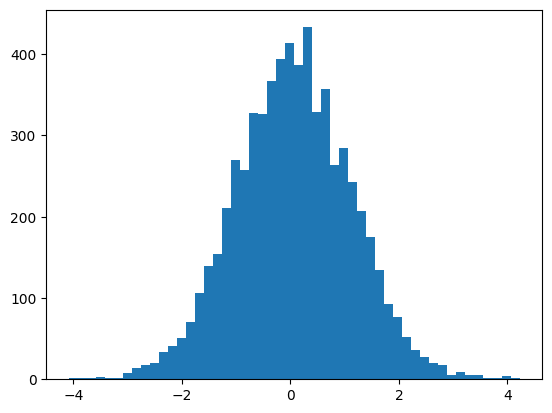

In [25]:
# tanh 입력값 hpreact 분포 확인
plt.hist(hpreact.view(-1).tolist(), bins=50)

(array([190., 187., 186., 151., 159., 163., 135., 126., 113., 143., 104.,
        105., 116.,  93., 109.,  91., 109.,  85., 112.,  85., 106.,  87.,
        109., 100., 103., 113.,  71., 123., 104.,  84.,  87., 101., 114.,
        124., 109., 105.,  81., 120., 133., 107., 130., 123., 122., 160.,
        155., 180., 190., 230., 236., 231.]),
 array([-9.99439120e-01, -9.59458897e-01, -9.19478674e-01, -8.79498451e-01,
        -8.39518228e-01, -7.99538004e-01, -7.59557781e-01, -7.19577558e-01,
        -6.79597335e-01, -6.39617112e-01, -5.99636889e-01, -5.59656665e-01,
        -5.19676442e-01, -4.79696219e-01, -4.39715996e-01, -3.99735773e-01,
        -3.59755549e-01, -3.19775326e-01, -2.79795103e-01, -2.39814880e-01,
        -1.99834657e-01, -1.59854434e-01, -1.19874210e-01, -7.98939872e-02,
        -3.99137640e-02,  6.64591789e-05,  4.00466824e-02,  8.00269055e-02,
         1.20007129e-01,  1.59987352e-01,  1.99967575e-01,  2.39947798e-01,
         2.79928021e-01,  3.19908245e-01,  3.59888

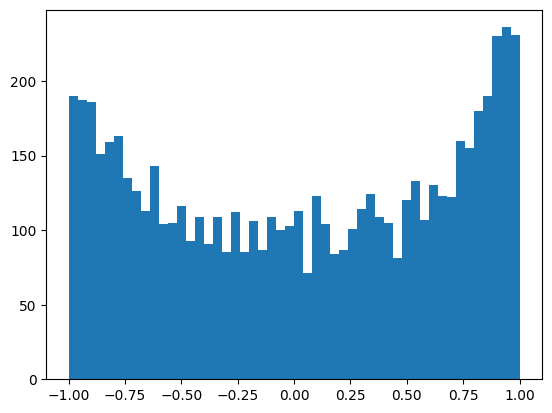

In [26]:
# h값 분포 확인
plt.hist(h.view(-1).tolist(), bins=50)

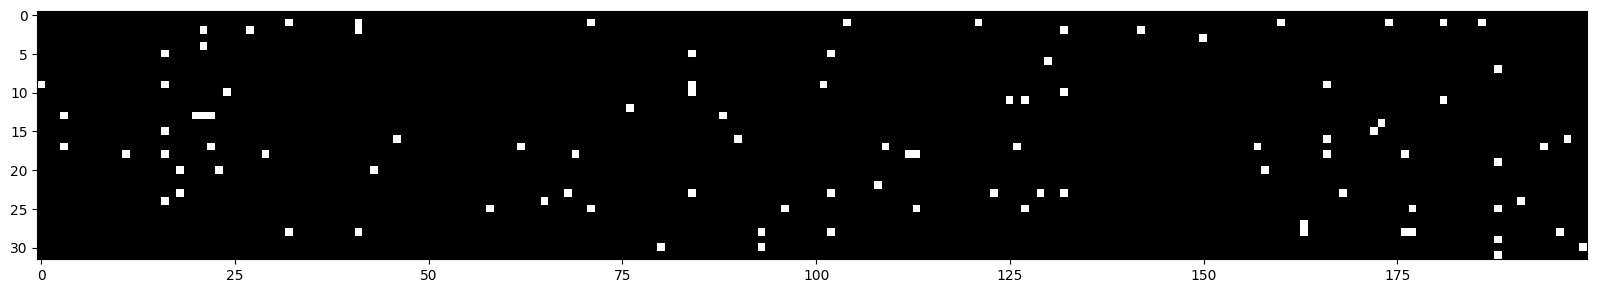

In [27]:
# h의 절댓값 중 0.99 이상인 것 확인
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99, cmap='gray', interpolation='nearest')

In [28]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += - lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())
    if i==20000:
        break

      0/ 200000: 3.2826
  10000/ 200000: 1.8561
  20000/ 200000: 2.0399


In [29]:
@torch.no_grad
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.196173906326294
val 2.2202322483062744


# kaiming initialization (He init)

가중치 값들을 얼마로 시작해야 좋을까요?   
[논문](https://arxiv.org/abs/1502.01852)

## 레이어를 거칠 때마다 분산이 달라진다

한 레이어에는 이런게 있죠
- weight(가중치)
- bias(편향)
- activation function (활성화 함수)   

모델에 입력 $x$를 넣으면   
$\text{activation function}(x\ @\ W + b)$을 거치면서 분산이 달라집니다.

In [30]:
# 행렬곱은 분산을 키웁니다.
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())

tensor(-0.0082) tensor(1.0016)
tensor(0.0061) tensor(3.2053)


행렬곱하면서 분산이 1인 확률변수 10개를 더한 것과 같으므로   
분산 $10$, 표준편차 $\sqrt{10} \approx 3.16$

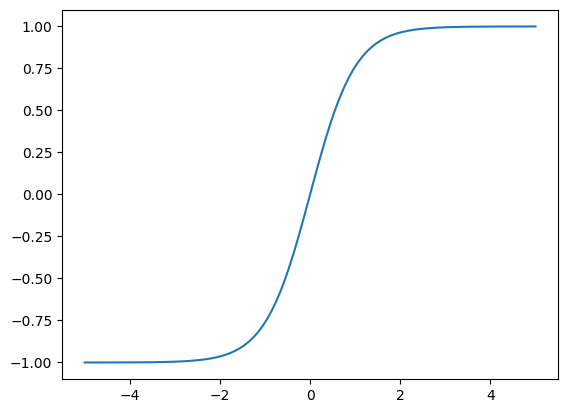

In [31]:
# tanh 활성화 함수 예시
x = torch.linspace(-5, 5, 100)
y = torch.tanh(x)
plt.plot(x, y)

In [32]:
x = torch.randn(100, 100)
print(x.mean(), x.std())
y = torch.tanh(x)
print(y.mean(), y.std()) # std를 3/5로 줄임

tensor(0.0129) tensor(0.9951)
tensor(0.0084) tensor(0.6278)


레이어가 깊다면?   
텐서 차원 수가 활성화 함수에 따라서   
분산이 점점 작아지거나 점점 커지겠죠!

## 분산이 극단적이 되면 생기는 문제

파라미터 업데이트는?   
$W \leftarrow W - \text{learning rate} \times \text{gradient}$

- **gradient vanishing:** 그레디언트가 너무 작으면 파라미터 업데이트가 잘 안됩니다.
- **gradient exploding:** 그레디언트 값이 너무 크면 loss 최솟값을 찾지 못하고 발산합니다.

## 레이어를 거쳐도 분산을 최대한 유지하는 게 좋다

- gradient vanishing / exploding 예방
- [모든 레이어가 같은 리듬으로 학습](https://datascience.stackexchange.com/questions/82917/why-do-we-want-the-variance-of-the-layers-to-remain-the-same-throughout-a-deep-n)

## 행렬곱에 맞서 가중치 분산을 줄이자

행렬곱을 하면 가중치의 행 개수 $n_{in}$에 루트 씌운 $\sqrt{n_{in}}$배만큼 표준편차큼 커집니다.   
std gain: $\sqrt{n_{in}}$

예를 들어,   
`(1000, 10) @ (10, 200)` 행렬곱을 한다면,

표준편차가 $\sqrt{10}$배 됩니다. -> std gain $\sqrt{10}$    
그만큼 줄여주면 됩니다.

In [34]:
x = torch.randn(1000, 10)
# w = torch.randn(10, 200)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())

tensor(-0.0113) tensor(0.9868)
tensor(0.0019) tensor(0.9937)


## 활성화 함수에 맞서 가중치 분산을 조절하자

[활성화 함수마다 std gain이 다릅니다](https://pytorch.org/docs/stable/nn.init.html)

`tanh`는 $\Large\frac{5}{3}$이니까  
반대로 가중치에 $\Large\frac{3}{5}$를 곱해주면 됩니다.

In [35]:
block_size = 3
vocab_size = 27
n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed), generator=g)
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g) * 5/3 / (n_embed*block_size)**0.5
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [36]:
# 첫번째 step loss 구하기
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += - lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())
    if i==20000:
        break

      0/ 200000: 3.2836
  10000/ 200000: 2.1097
  20000/ 200000: 2.3181


In [37]:
@torch.no_grad
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1845407485961914
val 2.2149617671966553


사실 가중치 초기화는 2015년쯤에는 학습 안정성 때메 중요했지만   
residual connection이나 정규화(배치, 레이어 등), Adam 옵티마이저 때문에 중요성이 떨어졌습니다.   
하지만 std gain을 상쇄하는 개념은 나중에 배울 attention에서도 나오니까 꼭 알아둡시다!!

# batch normalization (배치 정규화)
> 레이어 입력값 분포를 다 정규분포로 만들어버리고 학습하면 알아서 정규분포에 맞게 모델이 최적화되지 않을까?

1. 한 미니 배치별로 표준정규분포로 정규화 (평균 0, 분산 1)
2. scale($\gamma$)과 shift($\beta$)를 학습 $\rightarrow$ 활성화 함수 들어가기 전 레이어별 입력값의 최적의 분포를 찾음

[논문](https://arxiv.org/abs/1502.03167)

여담) [내부 공변량 변화](https://github.com/ndb796/Deep-Learning-Paper-Review-and-Practice/blob/master/lecture_notes/Batch_Normalization.pdf)는 논란의 여지가 있어 자세한 설명은 스킵하겠습니다...

(개인적으로, 정규분포는 가장 친숙하기도 하고 평균과 분산으로 조절할 수 있기 때문에 쓰인다고 생각해요!)

## 1. 각 미니 배치마다 값 정규화

$\Large \hat x_i \leftarrow \frac{x_i - \mu_B}{\sqrt{\sigma^2 + \epsilon}}$

크기가 32인 미니 배치에 대해 정규화해봅시다

In [38]:
hpreact.shape

torch.Size([32, 200])

In [39]:
hpreact.mean(), hpreact.std()

(tensor(0.0561, grad_fn=<MeanBackward0>),
 tensor(1.6928, grad_fn=<StdBackward0>))

In [40]:
bnmeani = hpreact.mean(0, keepdim=True)
bnstdi = hpreact.std(0, keepdim=True)

hpreact_norm = (hpreact-bnmeani) / bnstdi

hpreact_norm.mean(), hpreact_norm.std()

(tensor(3.1665e-10, grad_fn=<MeanBackward0>),
 tensor(0.9843, grad_fn=<StdBackward0>))

## 2. 레이어에 맞는 최적의 분포를 학습하자

다음 글자를 예측하는 태스크에서   
레이어 입력값 분포가 꼭 표준정규분포가 최고가 아닐 수 있습니다.   
scale, shift 학습을 통해 가장 적합한 분포를 찾을 수 있습니다.

$\Large\text{BN}_{\gamma, \beta}(x_i) \leftarrow \gamma \hat x + \beta$

In [41]:
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bngain * (hpreact_norm) + bnbias # 지금은 표준정규분포지만 학습하면 달라질 수 있음

tensor([[-0.0062,  0.2454, -0.4705,  ...,  0.2360,  0.0765, -0.4051],
        [ 0.1251, -0.4606, -0.9246,  ...,  0.3417, -1.8657,  0.7094],
        [-2.3505,  1.4045, -1.0823,  ...,  1.6064,  0.2200, -1.4777],
        ...,
        [ 0.5855,  0.4391,  0.3031,  ..., -0.5674,  0.8445, -0.0092],
        [ 0.4305,  0.2879,  0.3320,  ..., -0.0160, -0.3293, -0.6773],
        [ 0.0290,  0.5035,  0.7349,  ...,  0.5910, -0.1256, -0.1665]],
       grad_fn=<AddBackward0>)

`bnbias`가 있어서 `b1`은 필요 없어졌습니다

## 배치 정규화 학습

In [42]:
block_size = 3
vocab_size = 27
n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed), generator=g)
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g) * 5/3 / (n_embed*block_size)**0.5
# b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

# 학습 다 끝나고 나서 추론할 때 사용할 평균, 표준편차
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


학습 다 끝나고 나서 추론할 때 사용할
- 평균(`bnmean_running`)
- 표준편차(`bnstd_running`)

는 학습 중에 지수이동평균(EMA)로 구합니다!   

모든 학습 데이터에 대해 `hpreact`를 한번에 구하기 어렵고   
미니 배치인 `hpreact`를 만날 때마다 EMA로 구하는게 편하기 때문입니다.   
> 은사님: everybody is lazy

In [43]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)

    hpreact = embcat @ W1 #+ b1
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact-bnmeani) / bnstdi + bnbias

    with torch.no_grad():
        bnmean_running = 0.999*bnmean_running + 0.001*bnmeani
        bnstd_running = 0.999*bnstd_running + 0.001*bnstdi

    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += - lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())
    
    if i == 20000: break

      0/ 200000: 3.2841


  10000/ 200000: 2.1178
  20000/ 200000: 2.7035


In [44]:
split_loss('train')
split_loss('val')

train 2.4925217628479004
val 2.508549690246582


## batch normalization 단점
너무 미니 배치 분포에 의존합니다. (coupling)

- 추론할 때는 학습에서 구한 `bnmean_running`, `bnstd_running`을 사용합니다 $\rightarrow$ 추론 데이터랑 안맞을 수 있어요
- 만약 미니 배치 사이즈가 매우 작으면…? 평균, 표준편차가 제대로 학습 데이터 분포를 나타내지 않습니다.

이제는 layer normalization, RMS normalization, instance normalization, group normalization 같은 방식을 많이 씁니다.

batch norm이 처음으로 층이 깊을 때 잘 학습할 수 있는 방법으로 나와서 소개드렸습니다.

# 파이토치처럼 신경망 클래스 만들기

In [45]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [46]:
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)

            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar

        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x-xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

In [47]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [48]:
vocab_size = 27
n_embed = 10
block_size = 3
n_hidden = 100

g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed), generator=g)
layers = [
    Linear(n_embed*block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain of tanh
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46497


In [49]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # for debugging
    for p in parameters:
        p.grad=None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break # for debugging

      0/ 200000: 3.2972


# batch norm 없을 때 시각화
## forward & backward pass activation

딱 한 스텝 업데이트했을 때   
tanh 아웃풋과 그레디언트 그려봅시다.   
(tanh 값이 0.97보다 크면 포화라고 가정)

1. tanh 값이 x축이고 빈도가 y축
2. 기울기 값이 x축이고 빈도가 y축

### kaiming init 적용한 경우

layer 1 Tanh      : mean: -0.05, std: 0.76, saturated: 21.00%


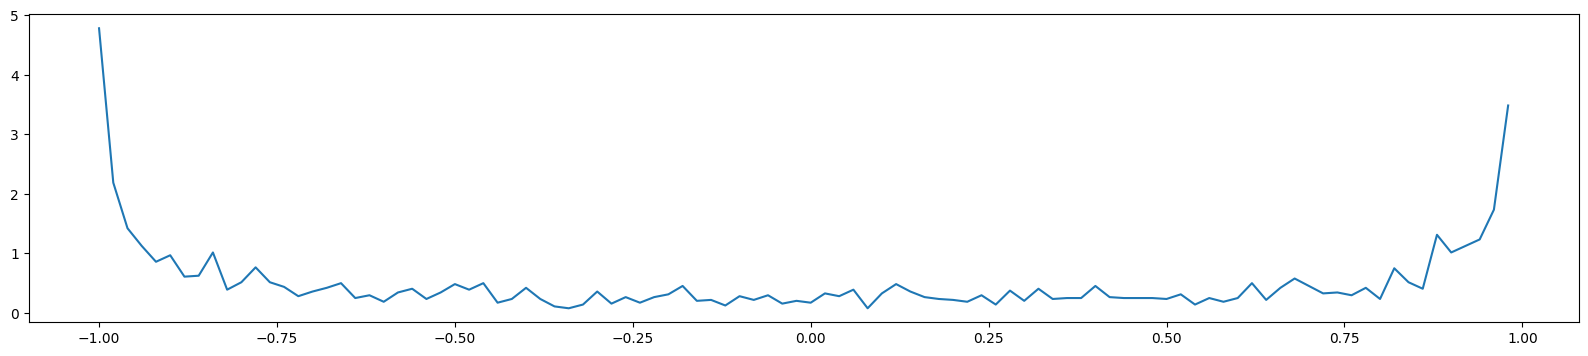

In [50]:
# 1번째 레이어(Tanh) 값 그려보기
plt.figure(figsize=(20,4))

layer = layers[1]
t = layer.out
print(f'layer 1 {layer.__class__.__name__:10s}: mean: {t.mean():.2f}, std: {t.std():.2f}, saturated: {(t.abs()>0.97).float().mean()*100:.2f}%')
hy, hx = torch.histogram(t, density=True) # histogram count, bin edges
plt.plot(hx[:-1].detach(), hy.detach()) # hx가 hy보다 숫자 하나 더 많아서 맞춰줍니다.

In [ ]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i , layer in enumerate(layers[:-1]): # exclude the output layer which is the softmax layer
    if isinstance(layer, Tanh):
        t = layer.out
        print(f'layer {i} {layer.__class__.__name__:10s}: mean: {t.mean():.2f}, std: {t.std():.2f}, saturated: {(t.abs()>0.97).float().mean()*100:.2f}%')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} (){layer.__class__.__name__}')
plt.legend(legends)
plt.title('activation distribution')

In [ ]:
# 1번째 레이어(Tanh) 그레디언트 그려보기
plt.figure(figsize=(20,4))

layer = layers[1]
t = layer.out.grad
print(f'layer 1 {layer.__class__.__name__:10s}: mean: {t.mean():+f}, std: {t.std():e}')
hy, hx = torch.histogram(t, density=True) # histogram count, bin edges
plt.plot(hx[:-1].detach(), hy.detach()) # hx가 hy보다 숫자 하나 더 많아서 맞춰줍니다.

In [ ]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i , layer in enumerate(layers[:-1]): # exclude the output layer which is the softmax layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f'layer {i} ({layer.__class__.__name__:10s}): mean: {t.mean():+f}, std: {t.std():e}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} (){layer.__class__.__name__}')
plt.legend(legends)
plt.title('gradient distribution')

그레디언트 분포가 크게 바뀌지 않습니다

## 가중치 gain을 작게하면 분산 감소
### 첫번째 스텝

In [54]:
vocab_size = 27
n_embed = 10
block_size = 3
n_hidden = 100

g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed), generator=g)
layers = [
    Linear(n_embed*block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain of tanh
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 0.5 # 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46497


In [55]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # for debugging
    for p in parameters:
        p.grad=None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break # for debugging

      0/ 200000: 3.2955


In [ ]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i , layer in enumerate(layers[:-1]): # exclude the output layer which is the softmax layer
    if isinstance(layer, Tanh):
        t = layer.out
        print(f'layer {i} {layer.__class__.__name__:10s}: mean: {t.mean():.2f}, std: {t.std():.2f}, saturated: {(t.abs()>0.97).float().mean()*100:.2f}%')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} (){layer.__class__.__name__}')
plt.legend(legends)
plt.title('activation distribution')

레이어를 거칠수록 분산이 작아집니다

In [ ]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i , layer in enumerate(layers[:-1]): # exclude the output layer which is the softmax layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f'layer {i} ({layer.__class__.__name__:10s}): mean: {t.mean():+f}, std: {t.std():e}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} (){layer.__class__.__name__}')
plt.legend(legends)
plt.title('gradient distribution')

레이어를 거칠수록 그레디언트 분산은 커집니다

$z = \text{tanh}(wx+b)$라면

$\Large\frac{\partial loss}{\partial x} = W^T(1-z^2)\frac{\partial loss}{\partial z}$

$W$ 행렬곱 때문에 $\Large\frac{\partial loss}{\partial x} < \frac{\partial loss}{\partial z}$

### 1000스텝

In [58]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # for debugging
    for p in parameters:
        p.grad=None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    if i==1000: break # for debugging

      0/ 200000: 3.2938


In [ ]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i , layer in enumerate(layers[:-1]): # exclude the output layer which is the softmax layer
    if isinstance(layer, Tanh):
        t = layer.out
        print(f'layer {i} {layer.__class__.__name__:10s}: mean: {t.mean():.2f}, std: {t.std():.2f}, saturated: {(t.abs()>0.97).float().mean()*100:.2f}%')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} (){layer.__class__.__name__}')
plt.legend(legends)
plt.title('activation distribution')

In [ ]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i , layer in enumerate(layers[:-1]): # exclude the output layer which is the softmax layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f'layer {i} ({layer.__class__.__name__:10s}): mean: {t.mean():+f}, std: {t.std():e}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} (){layer.__class__.__name__}')
plt.legend(legends)
plt.title('gradient distribution')

## 가중치 gain을 크게하면 분산 증가

In [61]:
vocab_size = 27
n_embed = 10
block_size = 3
n_hidden = 100

g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed), generator=g)
layers = [
    Linear(n_embed*block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain of tanh
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 3 # 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46497


In [62]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # for debugging
    for p in parameters:
        p.grad=None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break # for debugging

      0/ 200000: 3.2909


In [ ]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i , layer in enumerate(layers[:-1]): # exclude the output layer which is the softmax layer
    if isinstance(layer, Tanh):
        t = layer.out
        print(f'layer {i} {layer.__class__.__name__:10s}: mean: {t.mean():.2f}, std: {t.std():.2f}, saturated: {(t.abs()>0.97).float().mean()*100:.2f}%')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} (){layer.__class__.__name__}')
plt.legend(legends)
plt.title('activation distribution')

In [ ]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i , layer in enumerate(layers[:-1]): # exclude the output layer which is the softmax layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f'layer {i} ({layer.__class__.__name__:10s}): mean: {t.mean():+f}, std: {t.std():e}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} (){layer.__class__.__name__}')
plt.legend(legends)
plt.title('gradient distribution')

## Tanh 없애기 (fully linear case)

In [66]:
vocab_size = 27
n_embed = 10
block_size = 3
n_hidden = 100

g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed), generator=g)
layers = [
    Linear(n_embed*block_size, n_hidden), # Tanh(),
    Linear(n_hidden, n_hidden), #Tanh(),
    Linear(n_hidden, n_hidden), #Tanh(),
    Linear(n_hidden, n_hidden), #Tanh(),
    Linear(n_hidden, n_hidden), #Tanh(),
    Linear(n_hidden, vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain of tanh
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46497


In [67]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # for debugging
    for p in parameters:
        p.grad=None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break # for debugging

      0/ 200000: 3.2815


In [ ]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i , layer in enumerate(layers[:-1]): # exclude the output layer which is the softmax layer
    if isinstance(layer, Linear):
        t = layer.out
        print(f'layer {i} {layer.__class__.__name__:10s}: mean: {t.mean():.2f}, std: {t.std():.2f}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} (){layer.__class__.__name__}')
plt.legend(legends)
plt.title('activation distribution')

In [ ]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i , layer in enumerate(layers[:-1]): # exclude the output layer which is the softmax layer
    if isinstance(layer, Linear):
        t = layer.out.grad
        print(f'layer {i} ({layer.__class__.__name__:10s}): mean: {t.mean():+f}, std: {t.std():e}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} (){layer.__class__.__name__}')
plt.legend(legends)
plt.title('gradient distribution')

레이어 거쳐도 분산 비슷하게 유지!

## weight그레디언트 분포 살펴보기

다시 tanh 복구

In [70]:
vocab_size = 27
n_embed = 10
block_size = 3
n_hidden = 100

g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed), generator=g)
layers = [
    Linear(n_embed*block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain of tanh
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46497


In [71]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # for debugging
    for p in parameters:
        p.grad=None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break # for debugging

      0/ 200000: 3.2972


In [ ]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i , layer in enumerate(layers[:-1]): # exclude the output layer which is the softmax layer
    if isinstance(layer, Tanh):
        t = layer.out
        print(f'layer {i} {layer.__class__.__name__:10s}: mean: {t.mean():.2f}, std: {t.std():.2f}, saturated: {(t.abs()>0.97).float().mean()*100:.2f}%')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} (){layer.__class__.__name__}')
plt.legend(legends)
plt.title('activation distribution')

In [ ]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i , layer in enumerate(layers[:-1]): # exclude the output layer which is the softmax layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f'layer {i} ({layer.__class__.__name__:10s}): mean: {t.mean():+f}, std: {t.std():e}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} (){layer.__class__.__name__}')
plt.legend(legends)
plt.title('gradient distribution')

In [ ]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i , p in enumerate(parameters):
    t = p.grad
    if p.ndim==2:
        print(f'weight {str(tuple(p.shape)):10s} | mean {t.mean():+f} | std {t.std():e} | grad:data ratio {t.std() / p.std() :e}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution')

레이어끼리 std 차이가 많이 납니다   
마지막 레이어는 거의 10 ~ 100배 차이나는데,   
그러면 어떤 값은 혼자 10 ~ 100배 크게 값이 바뀝니다 (혼자 빨리 학습)   
이게 계속되면 학습이 불안정합니다

특히 `grad:data` std 비율을 봐도   
마지막 레이어에서 그레디언트 std가 데이터 std보다 2배 큽니다   
마지막 레이어만 크게 업데이트 됩니다 -> 불안정한 학습   

사실 첫번째 스텝이라 그렇지 많이 학습하면 고쳐집니다ㅎㅎ

### 1000스텝 학습

In [75]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # for debugging
    for p in parameters:
        p.grad=None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    if i==1000: break # for debugging

      0/ 200000: 3.2822


In [ ]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i , layer in enumerate(layers[:-1]): # exclude the output layer which is the softmax layer
    if isinstance(layer, Tanh):
        t = layer.out
        print(f'layer {i} {layer.__class__.__name__:10s}: mean: {t.mean():.2f}, std: {t.std():.2f}, saturated: {(t.abs()>0.97).float().mean()*100:.2f}%')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} (){layer.__class__.__name__}')
plt.legend(legends)
plt.title('activation distribution')

In [ ]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i , layer in enumerate(layers[:-1]): # exclude the output layer which is the softmax layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f'layer {i} ({layer.__class__.__name__:10s}): mean: {t.mean():+f}, std: {t.std():e}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} (){layer.__class__.__name__}')
plt.legend(legends)
plt.title('gradient distribution')

In [ ]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i , p in enumerate(parameters):
    t = p.grad
    if p.ndim==2:
        print(f'weight {str(tuple(p.shape)):10s} | mean {t.mean():+f} | std {t.std():e} | grad:data ratio {t.std() / p.std() :e}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution')

std 차이가 줄었네요!

## updata:data 비율

사실 위에 있는 grad: data ratio는 딱히 중요하지 않습니다.   
실제 데이터를 업데이트하는 건 `grad`가 아니라 `lr*grad`   
데이터의 std랑 `lr*grad`의 std를 그려봅시다

### 1000스텝

In [79]:
vocab_size = 27
n_embed = 10
block_size = 3
n_hidden = 100

g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed), generator=g)
layers = [
    Linear(n_embed*block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain of tanh
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46497


In [80]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # for debugging
    for p in parameters:
        p.grad=None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters]) # log for nice visualization

    if i >= 1000:
        break # for debugging

      0/ 200000: 3.2972


In [ ]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i , p in enumerate(parameters):
    if p.ndim==2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f'{i} {tuple(p.shape)}')
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)

1000분의 1 -> 로그 스케일에서 **-3**

모든 레이어에서 `update:data`가 -3 근처면 안정적이라고 합니다

## kaiming initialization 없이 1000 스텝

In [82]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) #/ fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [83]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # for debugging
    for p in parameters:
        p.grad=None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    if i==1000: break # for debugging

      0/ 200000: 2.5855


In [ ]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i , layer in enumerate(layers[:-1]): # exclude the output layer which is the softmax layer
    if isinstance(layer, Tanh):
        t = layer.out
        print(f'layer {i} {layer.__class__.__name__:10s}: mean: {t.mean():.2f}, std: {t.std():.2f}, saturated: {(t.abs()>0.97).float().mean()*100:.2f}%')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} (){layer.__class__.__name__}')
plt.legend(legends)
plt.title('activation distribution')

In [ ]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i , layer in enumerate(layers[:-1]): # exclude the output layer which is the softmax layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f'layer {i} ({layer.__class__.__name__:10s}): mean: {t.mean():+f}, std: {t.std():e}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} (){layer.__class__.__name__}')
plt.legend(legends)
plt.title('gradient distribution')

In [ ]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i , p in enumerate(parameters):
    t = p.grad
    if p.ndim==2:
        print(f'weight {str(tuple(p.shape)):10s} | mean {t.mean():+f} | std {t.std():e} | grad:data ratio {t.std() / p.std() :e}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution')

In [ ]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i , p in enumerate(parameters):
    if p.ndim==2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f'{i} {tuple(p.shape)}')
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)

레이어마다 다 다른 비율 $\rightarrow$ 학습 불안정

# batch norm 적용하고 시각화

In [88]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

## kaiming init 적용(gain 5/3) 1000 스텝

In [89]:
vocab_size = 27
n_embed = 10
block_size = 3
n_hidden = 100

g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed), generator=g)
layers = [
    Linear(n_embed*block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size), 
]

with torch.no_grad():
    # last layer: make less confident
    ## layers[-1].weight *= 0.1
    layers[-1].gamma *= 0.1
    # all other layers: apply gain of tanh
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


47024


In [90]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # for debugging
    for p in parameters:
        p.grad=None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters]) # log for nice visualization

    if i >= 1000:
        break # for debugging

      0/ 200000: 3.2741


In [ ]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i , layer in enumerate(layers[:-1]): # exclude the output layer which is the softmax layer
    if isinstance(layer, Tanh):
        t = layer.out
        print(f'layer {i} {layer.__class__.__name__:10s}: mean: {t.mean():.2f}, std: {t.std():.2f}, saturated: {(t.abs()>0.97).float().mean()*100:.2f}%')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} (){layer.__class__.__name__}')
plt.legend(legends)
plt.title('activation distribution')

In [ ]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i , layer in enumerate(layers[:-1]): # exclude the output layer which is the softmax layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f'layer {i} ({layer.__class__.__name__:10s}): mean: {t.mean():+f}, std: {t.std():e}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} (){layer.__class__.__name__}')
plt.legend(legends)
plt.title('gradient distribution')

In [ ]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i , p in enumerate(parameters):
    t = p.grad
    if p.ndim==2:
        print(f'weight {str(tuple(p.shape)):10s} | mean {t.mean():+f} | std {t.std():e} | grad:data ratio {t.std() / p.std() :e}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution')

In [ ]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i , p in enumerate(parameters):
    if p.ndim==2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f'{i} {tuple(p.shape)}')
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)

낫밷

## gain 0.2일 때 1000 스텝

In [95]:
vocab_size = 27
n_embed = 10
block_size = 3
n_hidden = 100

g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed), generator=g)
layers = [
    Linear(n_embed*block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size), 
]

with torch.no_grad():
    # last layer: make less confident
    ## layers[-1].weight *= 0.1
    layers[-1].gamma *= 0.1
    # all other layers: apply gain of tanh
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 0.2 # 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


47024


In [96]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # for debugging
    for p in parameters:
        p.grad=None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters]) # log for nice visualization

    if i >= 1000:
        break # for debugging

      0/ 200000: 3.2741


In [ ]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i , layer in enumerate(layers[:-1]): # exclude the output layer which is the softmax layer
    if isinstance(layer, Tanh):
        t = layer.out
        print(f'layer {i} {layer.__class__.__name__:10s}: mean: {t.mean():.2f}, std: {t.std():.2f}, saturated: {(t.abs()>0.97).float().mean()*100:.2f}%')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} (){layer.__class__.__name__}')
plt.legend(legends)
plt.title('activation distribution')

In [ ]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i , layer in enumerate(layers[:-1]): # exclude the output layer which is the softmax layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f'layer {i} ({layer.__class__.__name__:10s}): mean: {t.mean():+f}, std: {t.std():e}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} (){layer.__class__.__name__}')
plt.legend(legends)
plt.title('gradient distribution')

In [ ]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i , p in enumerate(parameters):
    t = p.grad
    if p.ndim==2:
        print(f'weight {str(tuple(p.shape)):10s} | mean {t.mean():+f} | std {t.std():e} | grad:data ratio {t.std() / p.std() :e}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution')

In [ ]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i , p in enumerate(parameters):
    if p.ndim==2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f'{i} {tuple(p.shape)}')
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)

낫밷

## gain 5 적용 후 1000 스텝

In [101]:
vocab_size = 27
n_embed = 10
block_size = 3
n_hidden = 100

g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed), generator=g)
layers = [
    Linear(n_embed*block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size), 
]

with torch.no_grad():
    # last layer: make less confident
    ## layers[-1].weight *= 0.1
    layers[-1].gamma *= 0.1
    # all other layers: apply gain of tanh
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5 # 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


47024


In [102]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # for debugging
    for p in parameters:
        p.grad=None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters]) # log for nice visualization

    if i >= 1000:
        break # for debugging

      0/ 200000: 3.2741


In [ ]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i , layer in enumerate(layers[:-1]): # exclude the output layer which is the softmax layer
    if isinstance(layer, Tanh):
        t = layer.out
        print(f'layer {i} {layer.__class__.__name__:10s}: mean: {t.mean():.2f}, std: {t.std():.2f}, saturated: {(t.abs()>0.97).float().mean()*100:.2f}%')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} (){layer.__class__.__name__}')
plt.legend(legends)
plt.title('activation distribution')

In [ ]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i , layer in enumerate(layers[:-1]): # exclude the output layer which is the softmax layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f'layer {i} ({layer.__class__.__name__:10s}): mean: {t.mean():+f}, std: {t.std():e}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} (){layer.__class__.__name__}')
plt.legend(legends)
plt.title('gradient distribution')

In [ ]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i , p in enumerate(parameters):
    t = p.grad
    if p.ndim==2:
        print(f'weight {str(tuple(p.shape)):10s} | mean {t.mean():+f} | std {t.std():e} | grad:data ratio {t.std() / p.std() :e}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution')

In [ ]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i , p in enumerate(parameters):
    if p.ndim==2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f'{i} {tuple(p.shape)}')
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)

낫밷

## kaiming init 없이 gain 1

In [107]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) #/ fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [108]:
vocab_size = 27
n_embed = 10
block_size = 3
n_hidden = 100

g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed), generator=g)
layers = [
    Linear(n_embed*block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size), 
]

with torch.no_grad():
    # last layer: make less confident
    ## layers[-1].weight *= 0.1
    layers[-1].gamma *= 0.1
    # all other layers: apply gain of tanh
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1.0 # 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


47024


In [109]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # for debugging
    for p in parameters:
        p.grad=None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters]) # log for nice visualization

    if i >= 1000:
        break # for debugging

      0/ 200000: 3.2741


In [ ]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i , layer in enumerate(layers[:-1]): # exclude the output layer which is the softmax layer
    if isinstance(layer, Tanh):
        t = layer.out
        print(f'layer {i} {layer.__class__.__name__:10s}: mean: {t.mean():.2f}, std: {t.std():.2f}, saturated: {(t.abs()>0.97).float().mean()*100:.2f}%')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} (){layer.__class__.__name__}')
plt.legend(legends)
plt.title('activation distribution')

In [ ]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i , layer in enumerate(layers[:-1]): # exclude the output layer which is the softmax layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f'layer {i} ({layer.__class__.__name__:10s}): mean: {t.mean():+f}, std: {t.std():e}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} (){layer.__class__.__name__}')
plt.legend(legends)
plt.title('gradient distribution')

In [ ]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i , p in enumerate(parameters):
    t = p.grad
    if p.ndim==2:
        print(f'weight {str(tuple(p.shape)):10s} | mean {t.mean():+f} | std {t.std():e} | grad:data ratio {t.std() / p.std() :e}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution')

In [ ]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i , p in enumerate(parameters):
    if p.ndim==2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f'{i} {tuple(p.shape)}')
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)

결론: batch norm 덕분에 gain이나 init 없이도 나름 안정적으로 학습 가능

# 마지막 200000 스텝 학습

In [114]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [115]:
vocab_size = 27
n_embed = 10
block_size = 3
n_hidden = 100

g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed), generator=g)
layers = [
    Linear(n_embed*block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size), 
]

with torch.no_grad():
    # last layer: make less confident
    ## layers[-1].weight *= 0.1
    layers[-1].gamma *= 0.1
    # all other layers: apply gain of tanh
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47024


In [116]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
# ud = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    # for layer in layers:
    #     layer.out.retain_grad() # for debugging
    for p in parameters:
        p.grad=None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2741
  10000/ 200000: 2.3065
  20000/ 200000: 2.0679
  30000/ 200000: 1.8747
  40000/ 200000: 2.0734
  50000/ 200000: 2.2466
  60000/ 200000: 1.7410
  70000/ 200000: 2.1487
  80000/ 200000: 2.2964
  90000/ 200000: 1.9552
 100000/ 200000: 2.3927
 110000/ 200000: 2.0764
 120000/ 200000: 2.2198
 130000/ 200000: 1.8738
 140000/ 200000: 1.6725
 150000/ 200000: 1.7779
 160000/ 200000: 2.0496
 170000/ 200000: 1.8952
 180000/ 200000: 2.2358
 190000/ 200000: 1.9265


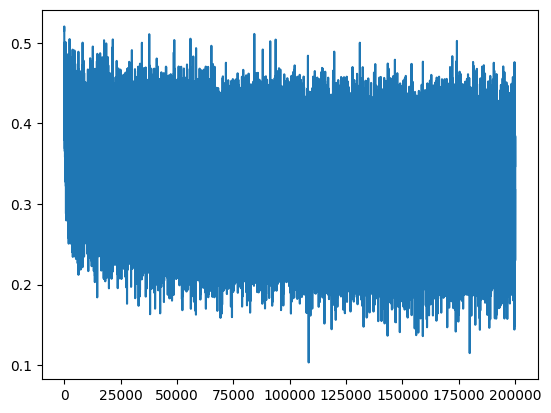

In [117]:
plt.plot(lossi)

In [118]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.0127663612365723
val 2.0870206356048584


In [119]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

sty.
raseunobii.
skylie.
samitsillinr.
kir.
jolie.
jigy.
nish.
jimmiaira.
harius.
azerah.
sadolynborciorgwonnin.
ana.
danie.
harliel.
amelarip.
daeshaysia.
emmina.
basen.
twan.


# 마무리

학습 안정화 3가지
1. **logit 값 다 비슷하게 만들기**: 마지막 output layer의 가중치, 편향을 0에 가깝게 초기화
2. **kaiming initialization**: 행렬곱과 활성화 함수 `std gain`을 상쇄하도록 가중치 초기화
3. **batch normalization**: 미니 배치 데이터 안에서 표준화하고 `scale`, `shift` 적용

# 참고

https://www.youtube.com/watch?v=P6sfmUTpUmc